<a href="https://colab.research.google.com/github/Henriquerezer/Dissertacao/blob/main/Abordagem_de_classifica%C3%A7%C3%A3o_(CLASSES_CONTINUAS).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [20]:
import matplotlib.pyplot as plt

def clarke_error_grid(ref_values, pred_values, title_string):

    assert len(ref_values) == len(pred_values), "Unequal number of values (reference : {}) (prediction : {}).".format(len(ref_values), len(pred_values))

    if max(ref_values) > 400 or max(pred_values) > 400:
        print("Input Warning: the maximum reference value {} or the maximum prediction value {} exceeds the normal physiological range of glucose (<400 mg/dl).".format(max(ref_values), max(pred_values)))
    if min(ref_values) < 0 or min(pred_values) < 0:
        print("Input Warning: the minimum reference value {} or the minimum prediction value {} is less than 0 mg/dl.".format(min(ref_values),  min(pred_values)))

    plt.clf()
    plt.figure(figsize=(7, 7))

    plt.scatter(ref_values, pred_values, marker='o', color='black', s=8)
    plt.title(title_string)
    plt.xlabel("Valores Referência (mg/dL)")
    plt.ylabel("Valores Preditos (mg/dL)")
    plt.xticks([0, 50, 100, 150, 200, 250, 300, 350, 400])
    plt.yticks([0, 50, 100, 150, 200, 250, 300, 350, 400])
    plt.gca().set_facecolor('white')

    plt.gca().set_xlim([0, 400])
    plt.gca().set_ylim([0, 400])
    plt.gca().set_aspect((400)/(400))

    plt.plot([0,400], [0,400], ':', c='black')
    plt.plot([0, 175/3], [70, 70], '-', c='black')
    plt.plot([175/3, 400/1.2], [70, 400], '-', c='black')
    plt.plot([70, 70], [84, 400],'-', c='black')
    plt.plot([0, 70], [180, 180], '-', c='black')
    plt.plot([70, 290],[180, 400],'-', c='black')
    plt.plot([70, 70], [0, 56], '-', c='black')
    plt.plot([70, 400], [56, 320],'-', c='black')
    plt.plot([180, 180], [0, 70], '-', c='black')
    plt.plot([180, 400], [70, 70], '-', c='black')
    plt.plot([240, 240], [70, 180],'-', c='black')
    plt.plot([240, 400], [180, 180], '-', c='black')
    plt.plot([130, 180], [0, 70], '-', c='black')

    plt.text(30, 15, "A", fontsize=15)
    plt.text(370, 260, "B", fontsize=15)
    plt.text(280, 370, "B", fontsize=15)
    plt.text(160, 370, "C", fontsize=15)
    plt.text(160, 15, "C", fontsize=15)
    plt.text(30, 140, "D", fontsize=15)
    plt.text(370, 120, "D", fontsize=15)
    plt.text(30, 370, "E", fontsize=15)
    plt.text(370, 15, "E", fontsize=15)

    zone = [0] * 5
    for i in range(len(ref_values)):
        if (ref_values[i] <= 70 and pred_values[i] <= 70) or (pred_values[i] <= 1.2*ref_values[i] and pred_values[i] >= 0.8*ref_values[i]):
            zone[0] += 1    #Zone A

        elif (ref_values[i] >= 180 and pred_values[i] <= 70) or (ref_values[i] <= 70 and pred_values[i] >= 180):
            zone[4] += 1    #Zone E

        elif ((ref_values[i] >= 70 and ref_values[i] <= 290) and pred_values[i] >= ref_values[i] + 110) or ((ref_values[i] >= 130 and ref_values[i] <= 180) and (pred_values[i] <= (7/5)*ref_values[i] - 182)):
            zone[2] += 1    #Zone C
        elif (ref_values[i] >= 240 and (pred_values[i] >= 70 and pred_values[i] <= 180)) or (ref_values[i] <= 175/3 and pred_values[i] <= 180 and pred_values[i] >= 70) or ((ref_values[i] >= 175/3 and ref_values[i] <= 70) and pred_values[i] >= (6/5)*ref_values[i]):
            zone[3] += 1    #Zone D
        else:
            zone[1] += 1    #Zone B

    return plt, zone

In [7]:
# Importação de bibliotecas necessárias

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.model_selection import  train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, f1_score, recall_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from imblearn.over_sampling import SMOTE


In [4]:
# Carregue um arquivo Excel em um DataFrame (substitua o caminho pelo seu próprio)
treino = pd.read_excel('/content/Treino (2).xlsx')

# Remova caracteres indesejados da coluna 'TEMP'
treino['TEMP'] = treino['TEMP'].str.replace("?", "")

# Remova o símbolo de porcentagem da coluna 'HUMIDADE'
treino['HUMIDADE'] = treino['HUMIDADE'].str.replace("%", "")

# Converta os valores na coluna 'TEMP' para o tipo de dado float
treino['TEMP'] = treino['TEMP'].astype(float)

# Converta os valores na coluna 'HUMIDADE' para o tipo de dado float
treino['HUMIDADE'] = treino['HUMIDADE'].astype(float)

# Defina uma função para mapear os valores da coluna 'mg/dL' em uma nova coluna 'categorica'
def definir_valor_nova_coluna(valor):
    if 360 > valor >= 345:
        return 352
    if 345 > valor >= 330:
        return 337
    if 330 > valor >= 315:
        return 322
    elif 315 > valor >= 300:
        return 307
    elif 300 > valor >= 285:
        return 292
    elif 285 > valor >= 270:
        return 277
    elif 270 > valor >= 255:
        return 262
    elif 255 >= valor >= 240:
        return 247
    elif 240 > valor >= 225:
        return 232
    elif 225 > valor >= 210:
        return 217
    elif 210 > valor >= 195:
        return 202
    elif 195 > valor >= 180:
        return 187
    elif 180 > valor >= 165:
        return 172
    elif 165 > valor >= 150:
        return 157
    elif 150 > valor >= 135:
        return 142
    elif 135 > valor >= 120:
        return 127
    elif 120 > valor >= 105:
        return 112
    elif 105 > valor >= 90:
        return 97
    elif 90 > valor >= 75:
        return 82
    elif 75 > valor >= 60:
        return 67
    elif 60 > valor >= 45:
        return 52
    elif 45 > valor >= 30:
        return 37
    elif 30 > valor >= 15:
        return 22
    elif 15 > valor >= 0:
        return 7
    else:
        return None  # Ou qualquer valor padrão para casos que não se encaixem nas condições
# Criar a nova coluna usando a função apply

# Aplique a função para criar a nova coluna 'categorica' com base na coluna 'mg/dL'
treino['categorica'] = treino['mg/dL'].apply(definir_valor_nova_coluna)

# Remova a coluna 'mg/dL', que não será mais necessária
treino = treino.drop('mg/dL', axis=1)

# Remova linhas com valores ausentes (NaN) no DataFrame
treino = treino.dropna()

# O DataFrame 'treino' agora foi limpo e a nova coluna 'categorica' foi criada com base nas condições especificadas.


<ipython-input-4-59481659352a>:5: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  treino['TEMP'] = treino['TEMP'].str.replace("?", "")


In [5]:
X = treino.drop('categorica', axis=1)
y = treino['categorica']

# Passo 1: Separar os dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, stratify=y)

# Passo 2: Aplicar SMOTE para balancear as classes no conjunto de treino
smote = SMOTE(random_state=42, sampling_strategy='minority', k_neighbors=1)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

model = ExtraTreesClassifier(max_depth = 10, min_samples_leaf = 1, min_samples_split = 2, n_estimators = 200, criterion='entropy')

# Definir o número de folds para a validação cruzada
num_folds = 6

# Realizar a validação cruzada
scores = cross_val_score(model, X_train_resampled, y_train_resampled, cv=num_folds, scoring='accuracy')

# Treinar o modelo com todos os dados de treinamento
model.fit( X_train_resampled, y_train_resampled)


y_pred = model.predict(X_test)

acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')

#print(f"Metrics for {model_name}:")
print(f"Accuracy: {acc:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Recall: {recall:.4f}")

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=6.
  warnings.warn(


Accuracy: 0.9545
F1 Score: 0.9496
Recall: 0.9545


In [6]:
reta = pd.read_excel('/content/Treino (2).xlsx')
reta = reta['mg/dL']

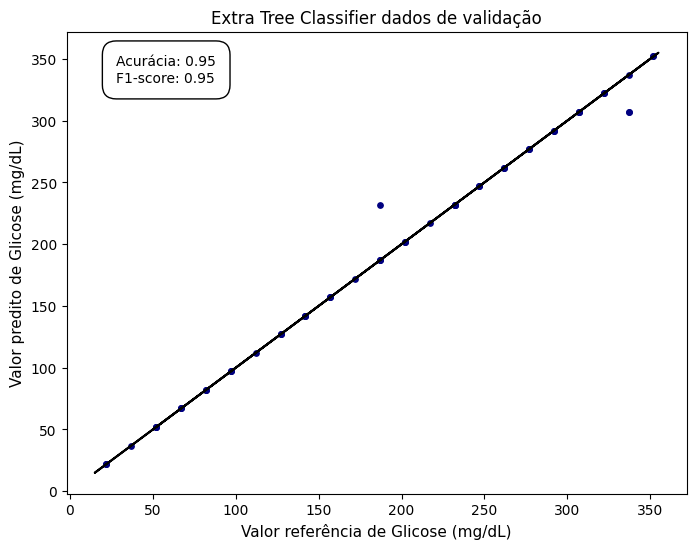

In [9]:
plt.figure(figsize=(8, 6))  # Define uma figura com largura 8 e altura 6
# Criar os pontos x para a linha reta
x_line = reta

# Criar os pontos y para a linha reta
y_line = reta

plt.plot(x_line, y_line, color='black', label='Linha Reta')
plt.scatter(y_test, y_pred, color='navy', label='Pontos Preditos', s= 15)

# Configurar os rótulos dos eixos
plt.xlabel('Valor referência de Glicose (mg/dL)', fontsize=11)
plt.ylabel('Valor predito de Glicose (mg/dL)', fontsize=11)

# Configurar o título do gráfico
plt.title('Extra Tree Classifier dados de validação')

# Adicionar os valores de RMSE e R2 no canto superior esquerdo
rmse_text = f'Acurácia: {acc:.2f}'
r2_text = f'F1-score: {f1:.2f}'
plt.text(0.08, 0.95, f'{rmse_text}\n{r2_text}', transform=plt.gca().transAxes,
         verticalalignment='top', bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=1'))

plt.savefig('EXTRA TREE VALIDAÇÃO.png')
# Exibir o gráfico
plt.show()

/usr/local/lib/python3.10/dist-packages/yellowbrick/classifier/base.py:232: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  warnings.warn(


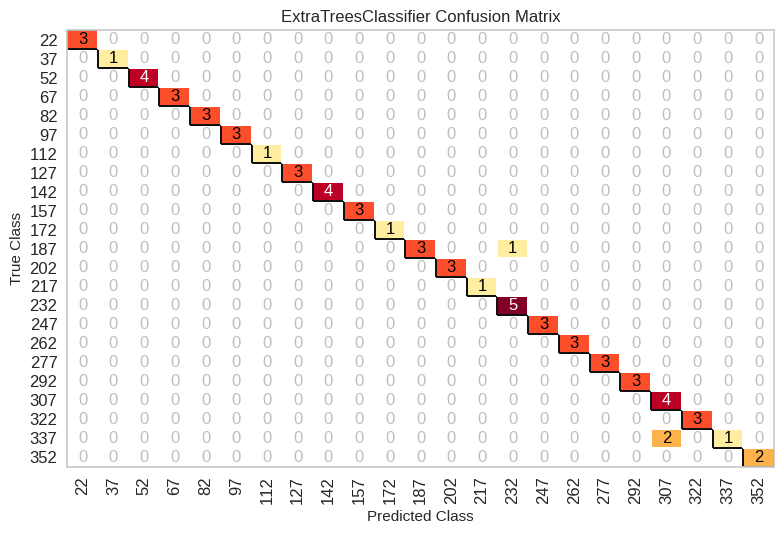

<Axes: title={'center': 'ExtraTreesClassifier Confusion Matrix'}, xlabel='Predicted Class', ylabel='True Class'>

In [10]:
from yellowbrick.classifier import ConfusionMatrix

cm = ConfusionMatrix(model)

cm.score( X_test, y_test)

plt.savefig('EXTRA TREE VALIDAÇÃO matriz de confusão.png')
cm.show()

# TESTE

In [11]:
data = pd.read_excel('/content/teste (2).xlsx')
data['TEMP'] = data['TEMP'].str.replace("?", "")
data['HUMIDADE'] = data['HUMIDADE'].str.replace("%", "")
data = data.dropna()
data['TEMP'] = data['TEMP'].astype(float)
data['HUMIDADE'] = data['HUMIDADE'].astype(float)
data.head()

def definir_valor_nova_coluna(valor):
    if 360 > valor >= 345:
        return 352
    if 345 > valor >= 330:
        return 337
    if 330 > valor >= 315:
        return 322
    elif 315 > valor >= 300:
        return 307
    elif 300 > valor >= 285:
        return 292
    elif 285 > valor >= 270:
        return 277
    elif 270 > valor >= 255:
        return 262
    elif 255 >= valor >= 240:
        return 247
    elif 240 > valor >= 225:
        return 232
    elif 225 > valor >= 210:
        return 217
    elif 210 > valor >= 195:
        return 202
    elif 195 > valor >= 180:
        return 187
    elif 180 > valor >= 165:
        return 172
    elif 165 > valor >= 150:
        return 157
    elif 150 > valor >= 135:
        return 142
    elif 135 > valor >= 120:
        return 127
    elif 120 > valor >= 105:
        return 112
    elif 105 > valor >= 90:
        return 97
    elif 90 > valor >= 75:
        return 82
    elif 75 > valor >= 60:
        return 67
    elif 60 > valor >= 45:
        return 52
    elif 45 > valor >= 30:
        return 37
    elif 30 > valor >= 15:
        return 22
    elif 15 > valor >= 0:
        return 7
    else:
        return None  # Ou qualquer valor padrão para casos que não se encaixem nas condições

# Criar a nova coluna usando a função apply
data['categorica'] = data['mg/dL'].apply(definir_valor_nova_coluna)
data = data.drop('mg/dL', axis = 1)
data = data.dropna()

<ipython-input-11-abe215e4ca24>:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  data['TEMP'] = data['TEMP'].str.replace("?", "")


In [12]:
reta = pd.read_excel('/content/teste (2).xlsx')
reta = reta['mg/dL']

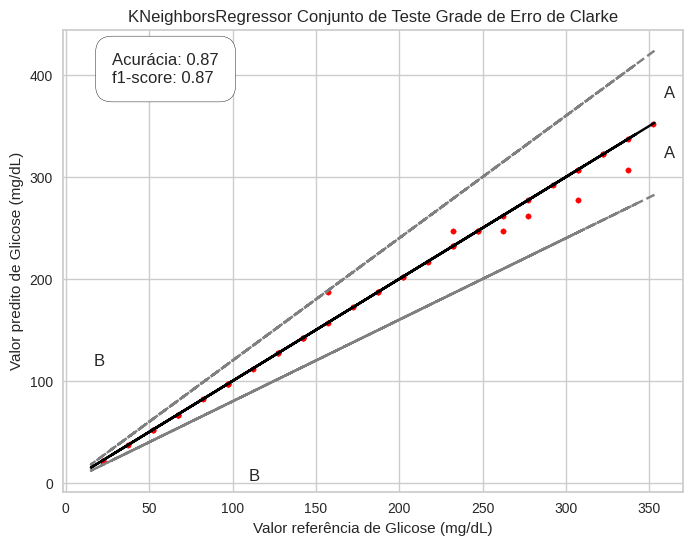

In [15]:
X = data.drop('categorica', axis=1)
y = data['categorica']

y_pred = model.predict(X)

acc = accuracy_score(y, y_pred)
f1 = f1_score(y, y_pred, average='weighted')
recall = recall_score(y, y_pred, average='weighted')



import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))  # Define uma figura com largura 8 e altura 6
# Criar os pontos x para a linha reta
x_line = reta

# Criar os pontos y para a linha reta
y_line = reta

percentage = 0.2
upper_line = y_line * (1 + percentage)
lower_line = y_line * (1 - percentage)

plt.plot(x_line, upper_line, color='gray', linestyle='--')
plt.plot(x_line, lower_line, color='gray', linestyle='--')

plt.plot(x_line, y_line, color='black', label='Linha Reta')
plt.scatter(y, y_pred, color='red', label='Pontos Preditos', s= 15)

# Configurar os rótulos dos eixos
plt.xlabel('Valor referência de Glicose (mg/dL)', fontsize=11)
plt.ylabel('Valor predito de Glicose (mg/dL)', fontsize=11)

# Configurar o título do gráfico
plt.title('KNeighborsRegressor Conjunto de Teste Grade de Erro de Clarke')

# Adicionar os valores de RMSE e R2 no canto superior esquerdo
rmse_text = f'Acurácia: {acc:.2f}'
r2_text = f'f1-score: {f1:.2f}'
plt.text(0.08, 0.95, f'{rmse_text}\n{r2_text}', transform=plt.gca().transAxes,
         verticalalignment='top', bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=1'))

plt.text(0.97, 0.88, 'A', transform=plt.gca().transAxes,
         verticalalignment='top')
plt.text(0.97, 0.75, 'A', transform=plt.gca().transAxes,
         verticalalignment='top')

plt.text(0.05, 0.3, 'B', transform=plt.gca().transAxes,
         verticalalignment='top')

plt.text(0.3, 0.05, 'B', transform=plt.gca().transAxes,
         verticalalignment='top')

plt.savefig('EXTRA TREE teste classes discretas.png')
# Exibir o gráfico
plt.show()

/usr/local/lib/python3.10/dist-packages/yellowbrick/classifier/base.py:232: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  warnings.warn(


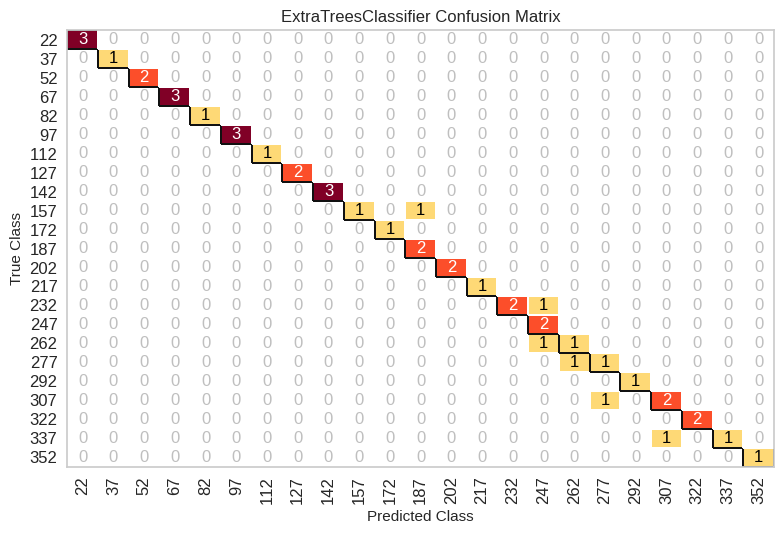

<Axes: title={'center': 'ExtraTreesClassifier Confusion Matrix'}, xlabel='Predicted Class', ylabel='True Class'>

In [16]:
from yellowbrick.classifier import ConfusionMatrix

cm = ConfusionMatrix(model)

cm.score(X, y)
plt.savefig('EXTRA TREE teste matriz confusão.png')
cm.show()

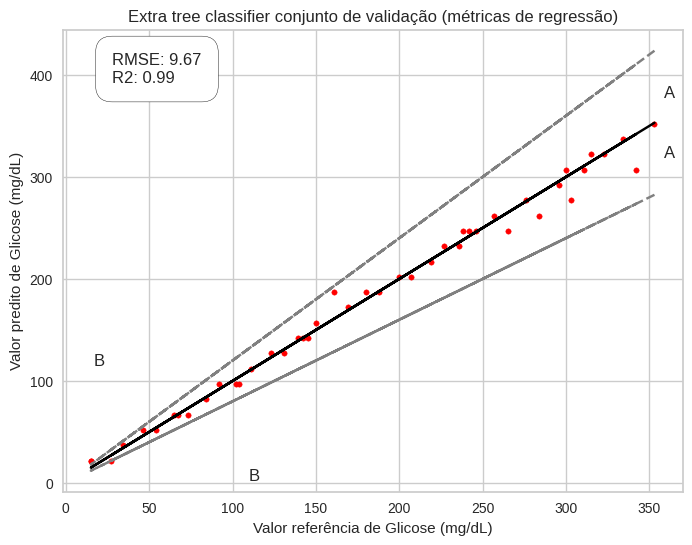

In [19]:
from sklearn.metrics import mean_squared_error, r2_score

reta = pd.read_excel('/content/teste (2).xlsx')
reta = reta['mg/dL']

X = data.drop('categorica', axis=1)
y = data['categorica']

y_pred = model.predict(X)

rmse = mean_squared_error(reta, y_pred, squared=False)
# Calcular o R²
r2 = r2_score(reta, y_pred)


import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))  # Define uma figura com largura 8 e altura 6
# Criar os pontos x para a linha reta
x_line = reta

# Criar os pontos y para a linha reta
y_line = reta

percentage = 0.2
upper_line = y_line * (1 + percentage)
lower_line = y_line * (1 - percentage)

plt.plot(x_line, upper_line, color='gray', linestyle='--')
plt.plot(x_line, lower_line, color='gray', linestyle='--')

plt.plot(x_line, y_line, color='black', label='Linha Reta')
plt.scatter(reta, y_pred, color='red', label='Pontos Preditos', s= 15)

# Configurar os rótulos dos eixos
plt.xlabel('Valor referência de Glicose (mg/dL)', fontsize=11)
plt.ylabel('Valor predito de Glicose (mg/dL)', fontsize=11)

# Configurar o título do gráfico
plt.title('Extra tree classifier conjunto de validação (métricas de regressão)')

# Adicionar os valores de RMSE e R2 no canto superior esquerdo
rmse_text = f'RMSE: {rmse:.2f}'
r2_text = f'R2: {r2:.2f}'
plt.text(0.08, 0.95, f'{rmse_text}\n{r2_text}', transform=plt.gca().transAxes,
         verticalalignment='top', bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=1'))

plt.text(0.97, 0.88, 'A', transform=plt.gca().transAxes,
         verticalalignment='top')
plt.text(0.97, 0.75, 'A', transform=plt.gca().transAxes,
         verticalalignment='top')

plt.text(0.05, 0.3, 'B', transform=plt.gca().transAxes,
         verticalalignment='top')

plt.text(0.3, 0.05, 'B', transform=plt.gca().transAxes,
         verticalalignment='top')

plt.savefig('EXTRA TREE teste rmse classes continuas.png')
# Exibir o gráfico
plt.show()

<Figure size 800x550 with 0 Axes>

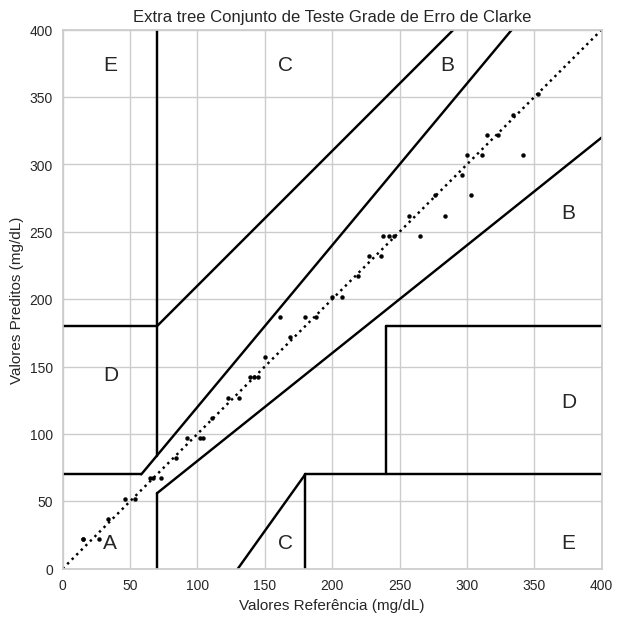

Pontos na Zona A: 45
Pontos na Zona B: 0
Pontos na Zona C: 0
Pontos na Zona D: 0
Pontos na Zona E: 0


In [21]:
# Dados de exemplo: valores de referência e medições do dispositivo
ref_values = reta.values
pred_values = y_pred

title_string = "Extra tree Conjunto de Teste Grade de Erro de Clarke"

# Chamando a função clarke_error_grid
plot, zone = clarke_error_grid(reta.values, y_pred, title_string)

# Definindo o tamanho da figura

plt.savefig('EXTRA TREE teste grade clarke.png')
# Exibindo o gráfico
plot.show()

print("Pontos na Zona A:", zone[0])
print("Pontos na Zona B:", zone[1])
print("Pontos na Zona C:", zone[2])
print("Pontos na Zona D:", zone[3])
print("Pontos na Zona E:", zone[4])

# NOVAS LEITURAS

In [23]:
novas_leituras = pd.read_excel('/content/teste_final.xlsx')
novas_leituras['TEMP'] = novas_leituras['TEMP'].str.replace("?", "")
novas_leituras['HUMIDADE'] = novas_leituras['HUMIDADE'].str.replace("%", "")
novas_leituras = novas_leituras.dropna()
novas_leituras['TEMP'] = novas_leituras['TEMP'].astype(float)
novas_leituras['HUMIDADE'] = novas_leituras['HUMIDADE'].astype(float)
def definir_valor_nova_coluna(valor):
    if 360 > valor >= 345:
        return 352
    if 345 > valor >= 330:
        return 337
    if 330 > valor >= 315:
        return 322
    elif 315 > valor >= 300:
        return 307
    elif 300 > valor >= 285:
        return 292
    elif 285 > valor >= 270:
        return 277
    elif 270 > valor >= 255:
        return 262
    elif 255 >= valor >= 240:
        return 247
    elif 240 > valor >= 225:
        return 232
    elif 225 > valor >= 210:
        return 217
    elif 210 > valor >= 195:
        return 202
    elif 195 > valor >= 180:
        return 187
    elif 180 > valor >= 165:
        return 172
    elif 165 > valor >= 150:
        return 157
    elif 150 > valor >= 135:
        return 142
    elif 135 > valor >= 120:
        return 127
    elif 120 > valor >= 105:
        return 112
    elif 105 > valor >= 90:
        return 97
    elif 90 > valor >= 75:
        return 82
    elif 75 > valor >= 60:
        return 67
    elif 60 > valor >= 45:
        return 52
    elif 45 > valor >= 30:
        return 37
    elif 30 > valor >= 15:
        return 22
    elif 15 > valor >= 0:
        return 7
    else:
        return None  # Ou qualquer valor padrão para casos que não se encaixem nas condições

# Criar a nova coluna usando a função apply
novas_leituras['categorica'] = novas_leituras['mg/dL'].apply(definir_valor_nova_coluna)
novas_leituras = novas_leituras.drop('mg/dL', axis = 1)
novas_leituras = novas_leituras.dropna()

reta = pd.read_excel('/content/teste_final.xlsx')
reta = reta['mg/dL']

X = novas_leituras.drop('categorica', axis=1)
y = novas_leituras['categorica']

y_pred = model.predict(X)

rmse = mean_squared_error(reta, y_pred, squared=False)
# Calcular o R²
r2 = r2_score(reta, y_pred)
print(rmse)

<ipython-input-23-6ed58be1ba80>:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  novas_leituras['TEMP'] = novas_leituras['TEMP'].str.replace("?", "")


4.273541610273245


<Figure size 800x550 with 0 Axes>

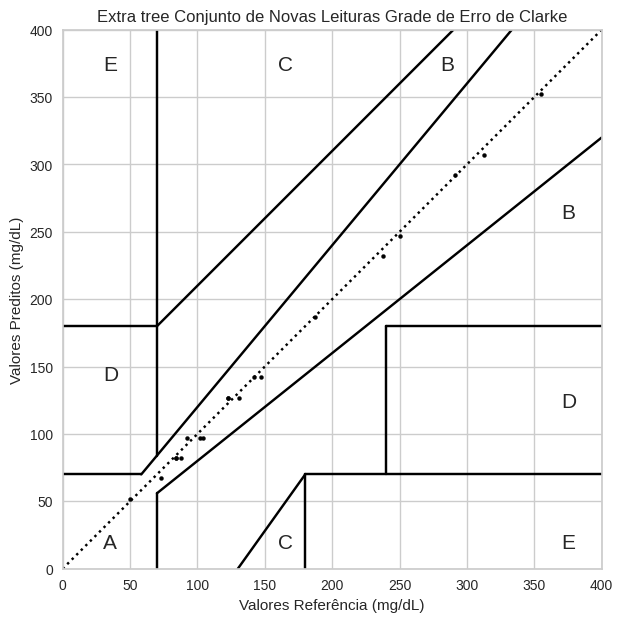

Pontos na Zona A: 19
Pontos na Zona B: 0
Pontos na Zona C: 0
Pontos na Zona D: 0
Pontos na Zona E: 0


In [24]:
# Dados de exemplo: valores de referência e medições do dispositivo
ref_values = reta.values
pred_values = y_pred

title_string = "Extra tree Conjunto de Novas Leituras Grade de Erro de Clarke"

# Chamando a função clarke_error_grid
plot, zone = clarke_error_grid(reta.values, y_pred, title_string)

# Definindo o tamanho da figura

plt.savefig('EXTRA TREE Novas leituras classes contínuas grade de clarke.png')
# Exibindo o gráfico
plot.show()

print("Pontos na Zona A:", zone[0])
print("Pontos na Zona B:", zone[1])
print("Pontos na Zona C:", zone[2])
print("Pontos na Zona D:", zone[3])
print("Pontos na Zona E:", zone[4])